In [14]:
import numpy as np
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

### Some auxiliary functions for QRAM

In [42]:
def meas_QRAM_best(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job



    ## the ordering in which we measure will be same just that it will have to be repeated a couole of times
    ## 1,0,3,2 to 1,1,0,0,3,3,2,2 for case of two 
    final_ord_mat = np.zeros([mc,len(div_decimal)])
    for i in range(len(div_decimal)):
        add = 0
        for j in range(mc):
            final_ord_mat[j,i] = int(div_decimal[i])*int(mc)
            final_ord_mat[j,i] += add
            add = add + 1
    ## now this matrix has to be concatinated onto one another
    final_ord = np.reshape(final_ord_mat,(int(final_ord_mat.size),1), order='F')
    
    
    
    ## now we will also need to input address orderings 
    add_ord = np.zeros(mc*len(div_decimal))
    j_last = 0    
    for i in range(0, len(div_decimal)):
         # the purpose of j_last is is to start from where the last loop stopped in i+j terms
        for j in range( j_last, j_last + mc):
            add_ord[i+j] = i
            j_last = j
            
    ## this one is here for bus orderings 
    bus_ord = np.zeros(0)
    one_ord = range(0, mc)
    for i in range(0,r):
        bus_ord = np.append(bus_ord,one_ord)
            

            
    ## finally adding the ccx gates which will copy out whatever is in the memory cells to the Bus
    for i in range(0, m ):
        qc.ccx(qr_r[int(add_ord[i])], qr_m[int(final_ord[i])], qr_bus[int(bus_ord[i])])
  
    return qc


In [43]:
def meas_QRAM(no_of_address_qubits,no_of_bits_in_memory_cell):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
   # cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job



    ## the ordering in which we measure will be same just that it will have to be repeated a couole of times
    ## 1,0,3,2 to 1,1,0,0,3,3,2,2 for case of two 
    final_ord_mat = np.zeros([mc,len(div_decimal)])
    for i in range(len(div_decimal)):
        add = 0
        for j in range(mc):
            final_ord_mat[j,i] = int(div_decimal[i])*int(mc)
            final_ord_mat[j,i] += add
            add = add + 1
    ## now this matrix has to be concatinated onto one another
    final_ord = np.reshape(final_ord_mat,(int(final_ord_mat.size),1), order='F')
    
    
    
    ## now we will also need to input address orderings 
    add_ord = np.zeros(mc*len(div_decimal))
    j_last = 0    
    for i in range(0, len(div_decimal)):
         # the purpose of j_last is is to start from where the last loop stopped in i+j terms
        for j in range( j_last, j_last + mc):
            add_ord[i+j] = i
            j_last = j
            
    ## this one is here for bus orderings 
    bus_ord = np.zeros(0)
    one_ord = range(0, mc)
    for i in range(0,r):
        bus_ord = np.append(bus_ord,one_ord)
            

            
    ## finally adding the ccx gates which will copy out whatever is in the memory cells to the Bus
    for i in range(0, m ):
        qc.ccx(qr_r[int(add_ord[i])], qr_m[int(final_ord[i])], qr_bus[int(bus_ord[i])])

    return qc         

In [44]:
## to functions that we will be using for concatination of "0" and "1" in front the numbers and the other one for addition for the conversion of the binary to decimal 
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1


## for convertign from decimal to binary 
def decimalToBinary(n,no_of_places):
    num = no_of_places ## this will be equal to mc
    binary = bin(n).replace("0b", "")
    if (len(binary) != num):
        i = num - len(binary)
        for j in range(0,i):
            binary = numConcat(0,binary)

    return binary

# QEA applied on the QRAM

## Diffuser

In [45]:
def S_0():
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a 
    m = (2**a)*mc 
    bus_yesa = mc+a  
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_b = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_b)
    
    
    ctr = []
    for j in range(a):
        ctr.append(j)
    for k in range(a+m+r,a+m+r+mc-1):
        ctr.append(k)
        
    qc.x(qr_a)
    qc.x(qr_b)
    qc.h(qr_b[mc-1])
    qc.mct(ctr,qr_b[mc-1])
    qc.h(qr_b[mc-1])
    qc.x(qr_a)
    qc.x(qr_b)

    return qc

## Bigger QRAM

It has 3 address Qubits and correspondingly $3*2^3$ = 24 memory lines for 8 memory cells with 3 bit capacity each.

### It stores [1,2,3,4,5,7,9,12,13,15] in the memory cells

In [46]:
def QRAM(no_of_address_qubits,no_of_bits_in_memory_cell, data):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc # no. of classical readout bits if we are only looking at the bus 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_yesa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    

    ## adding the state that will be qureied out and the memory can be stored here
    qc = qc.compose(input_add(a, mc))
    qc = qc.compose(mem_data(a, mc, data))
    
    
    ### here we will start with the branching
    # there is X gate at the second qubit first
   # qc.barrier()
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    #qc.barrier()
    
    # further branchings 
    if mc==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM(a,mc))

    return qc

In [47]:
def input_add(no_of_address_qubits,no_of_bits_in_memory_cell):
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    ## you can make the superposition here to query the QRAM 
    desired_vector = [
        1 / np.sqrt(10) ,
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 / np.sqrt(10),
        1 /np.sqrt(10),
        0,
        0,
        0,
        0,
        0,
        0]
    qc.initialize(desired_vector,[qr_a[0],qr_a[1],qr_a[2], qr_a[3] ])
    basis_gates = ['h', 'ry', 'cx', 'ccx','z', 'x', 'y', 'cz','ch','mct','p']
    input_add = transpile(qc, basis_gates=basis_gates, optimization_level=2)
    return input_add

In [48]:
def mem_data(no_of_address_qubits,no_of_bits_in_memory_cell, data):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
    ## each of data points should be smaller than 2**mc
    
    for i in range(0,len(data)):
        if data[i]>2**mc:
            print("Error!! The value of the data to be stored is bigger then the 2**mc")
            return
    
    bin_data = ["" for x in range(len(data))]
    ## the data needs to convert to binary from decimal
    for i in range(0,len(data)):
        bin_data[i] = decimalToBinary(data[i], mc)
        
    
    new_data = np.zeros([len(data), mc])
    
    # now we will be dividing all our divided
    for i in range(len(data)):
        for j in range(mc):
            new_data[i, j] = bin_data[i][j]
    
    ## fliping the matrix around so the ordering is proper according QISKIT
    flip_new_data = np.flip(new_data,1)
    ## this will be arranged in a row vector so that we can run a loop over it 
    new_data_row = np.reshape(flip_new_data,[1,mc*len(data)])
    
    for i in range(len(new_data_row[0])):
        if new_data_row[0,i] == 1:
            qc.x(qr_m[i])
            
    return qc

In [49]:
def Oracle2(): #to amplify 3 particularly # second one for even
    
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    bus_noa = mc
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    cr = ClassicalRegister(bus_noa, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)
    
#     qc.x(qr_bus[2])
#     qc.cz(qr_bus[2],qr_bus[0])
#     qc.x(qr_bus[2])
    
#     qc.x(qr_bus[0])
#     qc.z(qr_bus[0])
#     qc.x(qr_bus[0])
    
    qc.z(qr_bus[0])
    
    return qc

In [50]:
no_of_bits_in_memory_cell = 4
no_of_address_qubits = 4


def G(no_of_bits_in_memory_cell,no_of_address_qubits):
    mc = no_of_bits_in_memory_cell
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = (2**a)*mc # no. of memory qubits
    bus_yesa = mc+a # no. of classical readout bits required when we also wanna see address 
    #bus_noa = mc

    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(mc, "bus")
    #cr = ClassicalRegister(bus_noa, "readout")

    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus)

    #qc = qc.compose(QRM(no_of_address_qubits,no_of_bits_in_memory_cell))
    #qc.barrier()

    reps = 1

    for rep in range(reps):
        qc = qc.compose(Oracle2())
        #qc.barrier()
        qc = qc.compose(qcd)
        #qc.barrier()
        qc = qc.compose(S_0())
        #qc.barrier()
        qc = qc.compose(A(38))
        #qc.barrier()

    # for i in range(0,a):
    #     qc.measure(qr_a[i],cr[i])

    #qc.measure(qr_bus, cr)

    #qc.draw()
    return qc

In [54]:
n=88
grit = G(no_of_bits_in_memory_cell,no_of_address_qubits).to_gate()
grit.label = "Grover"
cgrit = grit.control()

In [52]:
def A(n):
    n = 88
    qc = QRAM(4,4,[1,2,3,4,5,7,9,12,13,15,0,0,0,0,0,0])
    
    Aa = qc.to_gate()
    Aa.name = 'A'

    return Aa

In [55]:
n = 88
qcd = A(n).inverse()
qcd.label = 'Ad'

In [56]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    
    qq = circuit.to_gate()
    qq.name = 'QFT'
    
    return qq

In [57]:
n=4
qft_dagger = qft(n).inverse()
qft_dagger.label = "QFT†"

In [58]:
c = 4  
n = 88   
qc = QuantumCircuit(n+c, c) # Circuit with n+t qubits and t classical

#qc.append(qft(c), range(c))
qc.h(list(range(c)))

#qc.p(0,list(range(3)))

qc.append(A(n), list(range(c,c+n)))

# The Initial state for the first test case is taken as equal superposition
# for qubit in range(c, c+n):
#     qc.h(qubit)

    
qc.barrier()
    
# Begin controlled Grover iterations
iterations = 1
for qubit in range(c):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(c, n+c)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(c))

# Measure counting qubits
qc.measure(range(c), range(c))

In [54]:
qc.draw()

┌───┐  ░                                                 ┌───────┐┌─┐   »
 q_0: ─┤ H ├──░──────■──────────────────────────────────────────┤0      ├┤M├───»
       ├───┤  ░      │                                          │       │└╥┘┌─┐»
 q_1: ─┤ H ├──░──────┼───────────■──────────────────────────────┤1      ├─╫─┤M├»
       ├───┤  ░      │           │                              │  QFT† │ ║ └╥┘»
 q_2: ─┤ H ├──░──────┼───────────┼───────────■──────────────────┤2      ├─╫──╫─»
       ├───┤  ░      │           │           │                  │       │ ║  ║ »
 q_3: ─┤ H ├──░──────┼───────────┼───────────┼───────────■──────┤3      ├─╫──╫─»
      ┌┴───┴┐ ░ ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐└───────┘ ║  ║ »
 q_4: ┤0    ├─░─┤0         ├┤0         ├┤0         ├┤0         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
 q_5: ┤1    ├─░─┤1         ├┤1         ├┤1         ├┤1         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
 q_6: ┤2    ├─░─┤2         ├┤2         ├┤2         ├┤2         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
 q_7: ┤3    ├─░─┤3         ├┤3         ├┤3         ├┤3         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
 q_8: ┤4    ├─░─┤4         ├┤4         ├┤4         ├┤4         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
 q_9: ┤5    ├─░─┤5         ├┤5         ├┤5         ├┤5         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_10: ┤6    ├─░─┤6         ├┤6         ├┤6         ├┤6         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_11: ┤7    ├─░─┤7         ├┤7         ├┤7         ├┤7         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_12: ┤8    ├─░─┤8         ├┤8         ├┤8         ├┤8         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_13: ┤9    ├─░─┤9         ├┤9         ├┤9         ├┤9         ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_14: ┤10   ├─░─┤10        ├┤10        ├┤10        ├┤10        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_15: ┤11   ├─░─┤11        ├┤11        ├┤11        ├┤11        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_16: ┤12   ├─░─┤12        ├┤12        ├┤12        ├┤12        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_17: ┤13   ├─░─┤13        ├┤13        ├┤13        ├┤13        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_18: ┤14   ├─░─┤14        ├┤14        ├┤14        ├┤14        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_19: ┤15   ├─░─┤15        ├┤15        ├┤15        ├┤15        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_20: ┤16   ├─░─┤16        ├┤16        ├┤16        ├┤16        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_21: ┤17   ├─░─┤17        ├┤17        ├┤17        ├┤17        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_22: ┤18   ├─░─┤18        ├┤18        ├┤18        ├┤18        ├──────────╫──╫─»
      │   A │ ░ │   Grover ││   Grover ││   Grover ││   Grover │          ║  ║ »
q_23: ┤19   ├─░─┤19        ├┤19        ├┤19        ├┤19        ├──────────╫──╫─»
      │     │ ░ │          ││          ││          ││          │          ║  ║ »
q_24: ┤20   ├─░─┤20        ├┤20       

In [59]:
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

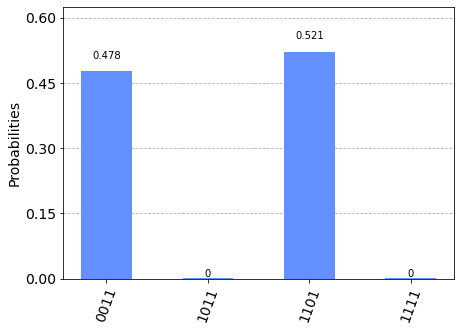

In [60]:
backend = provider.get_backend('simulator_mps')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

## Solutions are odd numbers, 7 odd numbers present in memory

In [61]:
ans = max(counts, key=counts.get)
max_meas = int(ans,2)

print("Max : ",max_meas)

theta = (max_meas/(2**c))*math.pi
print("Theta = %.5f" % theta)

N = 10
a = math.sin(theta)**2
print("a = %.2f"% a)
M = N * a
print("No. of Solutions = %.1f" % (N-M))

Max :  13
Theta = 2.55254
a = 0.31
No. of Solutions = 6.9
